In [1]:
import sys

import pandas as pd

sys.path.append('/Users/samrelins/Documents/LIDA/dental_project/src/')

from edrecs_context_data_prep import *
import plotly.express as px
from causalnex.structure.notears import from_pandas
from causalnex.discretiser import Discretiser
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE
from causalnex.network import BayesianNetwork
from IPython.display import Image


In [2]:
data_dir = "/Users/samrelins/Documents/LIDA/dental_project/data/"
context_data, _ = prep_context_ga_data(data_dir)
context_data = (context_data
                .pipe(convert_sen_categories)
                .pipe(convert_ethnicity_categories)
                .pipe(rename_context_cols))
drop_cols = ["entity_id", "has_edrecs_context", "has_edcont",
             "looked_after", "gifted", "birthday_academic_term"]
context_data.drop(drop_cols, axis=1, inplace=True)
context_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7846 entries, 9171 to 2049
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   year_started_school  7846 non-null   int16  
 1   eal                  7846 non-null   int16  
 2   ethnicity            7846 non-null   int16  
 3   fsm                  7846 non-null   int16  
 4   gender               7846 non-null   int16  
 5   sen                  7846 non-null   int16  
 6   has_dental_ga        7846 non-null   float64
dtypes: float64(1), int16(6)
memory usage: 214.5 KB


# Simple DAG describing No of Extractions

## Infer Network Structure

start by getting causalnex to infer network structure from data

/opt/anaconda3/envs/DentalEnv/lib/python3.8/site-packages/pygraphviz/agraph.py:1390: RuntimeWarning: Warning: node 'year_started_school', graph '' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


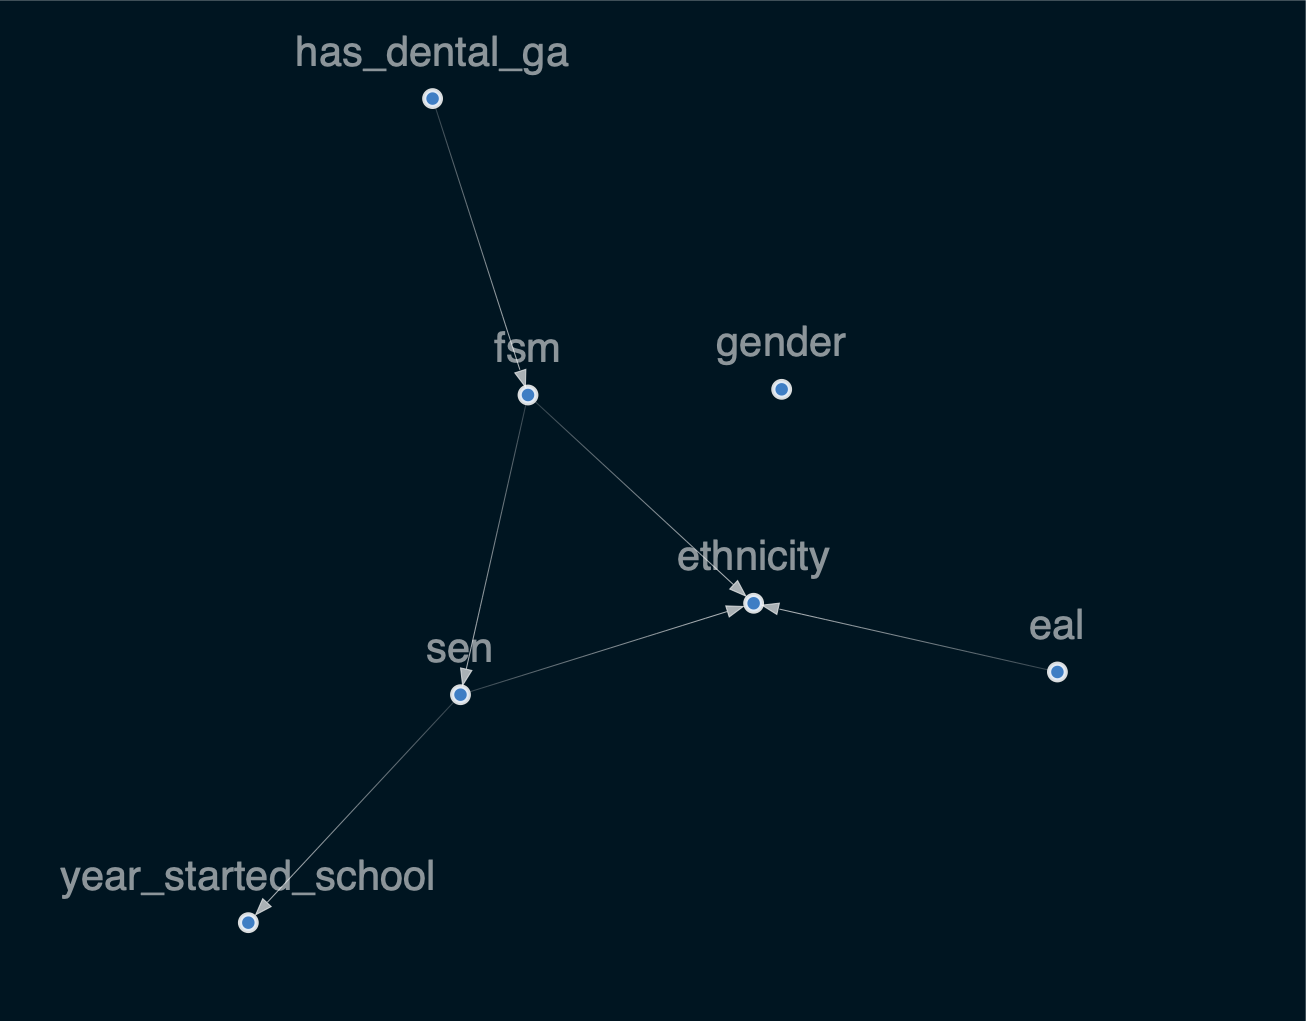

In [4]:

sm = from_pandas(context_data)

sm.remove_edges_below_threshold(0.8)
viz = plot_structure(
    sm,
    graph_attributes={"scale": "1"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK
)

Image(viz.draw(format="png"))

* having a dental GA obviously doesn't cause free school meals
* plus other nonesense causality - remove these edges
* ethnicity definitely causes eal - add this edge

In [5]:
sm = from_pandas(context_data,
                 tabu_edges=[("has_dental_ga", "fsm"),
                             ("eal", "ethnicity"),
                             ("sen", "ethnicity"),
                             ("fsm", "sen")],
                 w_threshold=0.8)

sm.add_edge("ethnicity", "eal")

viz = plot_structure(
    sm,
    graph_attributes={"scale": "1"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK
)

Image(viz.draw(format="png"))

/opt/anaconda3/envs/DentalEnv/lib/python3.8/site-packages/pygraphviz/agraph.py:1390: RuntimeWarning: Warning: node 'year_started_school', graph '' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


* has_dental_ga now considered independent of other variables - not good as this implies no interaction between observations and target variable
* try adding edge between FSM and has_dental_ga - literature suggests link between socioeconomic status and bad dental outcomes
* also remove other nonesense edges

/opt/anaconda3/envs/DentalEnv/lib/python3.8/site-packages/pygraphviz/agraph.py:1390: RuntimeWarning: Warning: node 'year_started_school', graph '' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


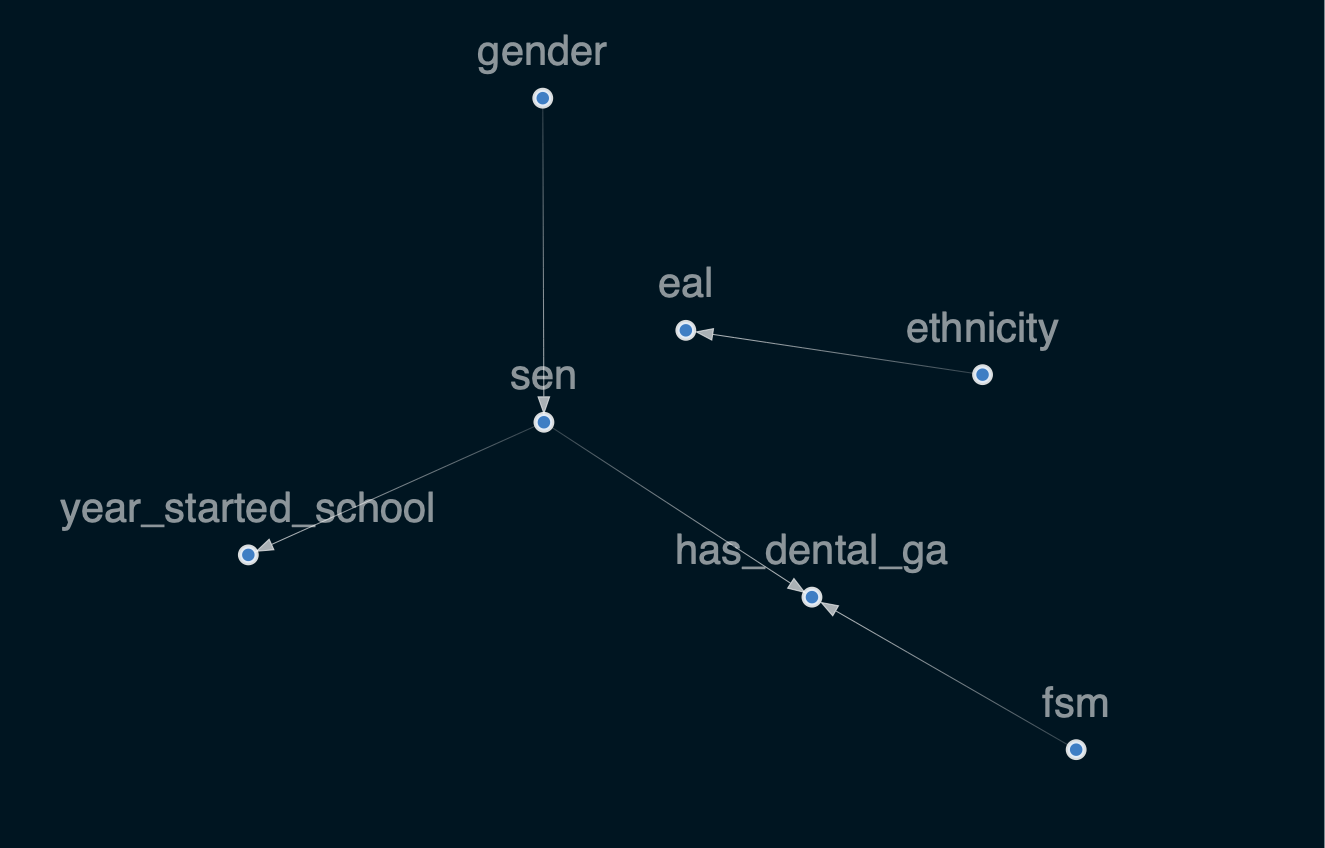

In [15]:
sm = from_pandas(context_data,
                 tabu_edges=[("has_dental_ga", "fsm"),
                             ("eal", "ethnicity"),
                             ("has_dental_ga", "gender"),
                             ("has_dental_ga", "ethnicity"),
                             ("year_started_school", "ethnicity"),
                             ("sen", "ethnicity"),
                             ("sen", "eal"),
                             ("gender", "ethnicity"),
                             ("gender", "eal"),
                             ("fsm", "ethnicity"),
                             ("fsm", "eal"),
                             ("fsm", "gender"),
                             ("fsm", "sen")],
                 w_threshold=0.8)

sm.add_edge("ethnicity", "eal")
sm.add_edge("fsm", "has_dental_ga")
sm.add_edge("sen", "has_dental_ga")

viz = plot_structure(
    sm,
    graph_attributes={"scale": "1"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK
)

Image(viz.draw(format="png"))

* data now imples fsm and dental ga's are independent of rest of variables - not good